In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from nilearn import image, plotting

from dd_kable_analysis.config_loader import load_config

# Check model outputs and run basic QA

## Load Configuration and Paths for QA Output
Import required libraries, load configuration, and define output/log directories for QA checks.

### Note: After running this post-analysis, the log files will be deleted.

In [2]:
cfg = load_config()
output_root = Path(cfg.output_root) / 'beta_series' / 'first_level'
logs_dir = Path(
    '/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/logs'
)

print(output_root)
print(logs_dir)

# Note: log files will be deleted after they are checked

/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/derivatives/analysis_output/beta_series/first_level
/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/logs


## Batch Verification of Output Maps and Logs
### If slurm err/out files still exist, run the following

Note, this assumes the log directory only has one set of err/log file from running it the beta series analysis once.

In [3]:
# --- Batch-run verification (run after jobs finish) ---
# (logs may have been deleted)
good_subs = pd.read_csv(
    cfg.subject_lists / 'initial_qa_pass_and_mask_pass_subjects_runs.csv'
)

output_root = Path(cfg.output_root) / 'beta_series' / 'first_level'
logs_dir = Path(
    '/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/logs'
)

success_pattern = re.compile(
    r'Analysis complete for sub-(?P<sub_id>\w+), run (?P<run>\d+)'
    r'|SUCCESS: Analysis completed for sub-(?P<sub_id2>\w+), run (?P<run2>\d+)'
)

success_pairs = set()
for log_file in sorted(logs_dir.glob('beta_series_*.out')):
    try:
        text = log_file.read_text()
    except Exception:
        continue
    for match in success_pattern.finditer(text):
        sub_id = match.group('sub_id') or match.group('sub_id2')
        run = match.group('run') or match.group('run2')
        success_pairs.add((sub_id, int(run)))


def find_logs_for_subrun(logs_dir: Path, sub_id: str, run: int):
    # Use your batch script's printed strings (these appear even on failure)
    pat = re.compile(
        rf'(SUCCESS|FAILED):.*sub-{re.escape(sub_id)}, run {run}\b'
        rf'|Subject:\s*{re.escape(sub_id)}\b.*?\n\s*Run:\s*{run}\b',
        flags=re.DOTALL,
    )

    for out_path in sorted(logs_dir.glob('beta_series_*.out')):
        try:
            txt = out_path.read_text()
        except Exception:
            continue
        if pat.search(txt):
            err_path = out_path.with_suffix('.err')  # swaps .out -> .err
            return str(out_path), str(err_path) if err_path.exists() else None

    return None, None


def count_maps(sub_id: str, run: int):
    out_dir = output_root / f'sub-{sub_id}' / 'contrast_estimates'
    if not out_dir.exists():
        return 0, out_dir
    files = list(
        out_dir.glob(
            f'sub-{sub_id}_ses-*_task-*_run-{run}_contrast-*_output-effectsize.nii.gz'
        )
    )
    return len(files), out_dir


rows = []
for _, row in good_subs.iterrows():
    sub_id = row['sub_id']
    run = int(row['run'])
    n_maps, out_dir = count_maps(sub_id, run)
    out_log, err_log = find_logs_for_subrun(logs_dir, sub_id, run)
    rows.append(
        {
            'sub_id': sub_id,
            'run': run,
            'output_dir': str(out_dir),
            'n_maps': n_maps,
            'has_maps': n_maps > 0,
            'log_success': (sub_id, run) in success_pairs,
            'out_log': out_log,
            'err_log': err_log,
        }
    )

summary = pd.DataFrame(rows)
summary['status'] = summary.apply(
    lambda r: 'ok'
    if r.has_maps and r.log_success
    else 'missing'
    if not r.has_maps
    else 'no_log_success',
    axis=1,
)

print(summary['status'].value_counts())

failed = summary[summary['status'] != 'ok']


status
ok         439
missing      1
Name: count, dtype: int64


### If there were failures use this to look at the log/err files
One subject had a ton of missing trials in one run and that one analysis will always fail,

In [4]:
def tail_text(path, n=80):
    lines = Path(path).read_text(errors='replace').splitlines()
    return '\n'.join(lines[-n:])


for _, r in failed.iterrows():
    out_path = r['out_log']
    if not out_path:
        continue

    print('=' * 80)
    print(f'sub={r["sub_id"]} run={r["run"]}  out_log={out_path}')
    print('-' * 80)
    print(tail_text(out_path, n=120))  # adjust n

sub=dmp0063 run=2  out_log=/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/logs/beta_series_16440729_21.out
--------------------------------------------------------------------------------
SLURM Job ID: 16441025
SLURM Array Task ID: 21
Running on node: sh03-06n06.int
Starting at: Fri Feb 20 06:42:15 PST 2026

Processing:
  Subject: dmp0063
  Session: scan1
  Run: 2

Loading configuration...

Running Beta Series Analysis
Subject: dmp0063
Run: 2

Step 1/5: Fetching BOLD data...
  ✓ BOLD file: sub-dmp0063_ses-scan1_task-itc_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz

Step 2/5: Creating design matrix...
  ✗ Error creating design matrix: ❌ 16 trials for sub dmp0063, run 2 are clipped. Cannot generate design matrix.

FAILED: Analysis failed for sub-dmp0063, run 2 (exit code: 1)
Finished at: Fri Feb 20 06:42:22 PST 2026


## Checking output images

This will plot the effect size maps for all contrasts for a given subject/run.

Since I did not apply spatial smoothing in `FirstLevelModel` I will apply it to the images before displaying them here (I'm more accustomed to viewing smoothed images)

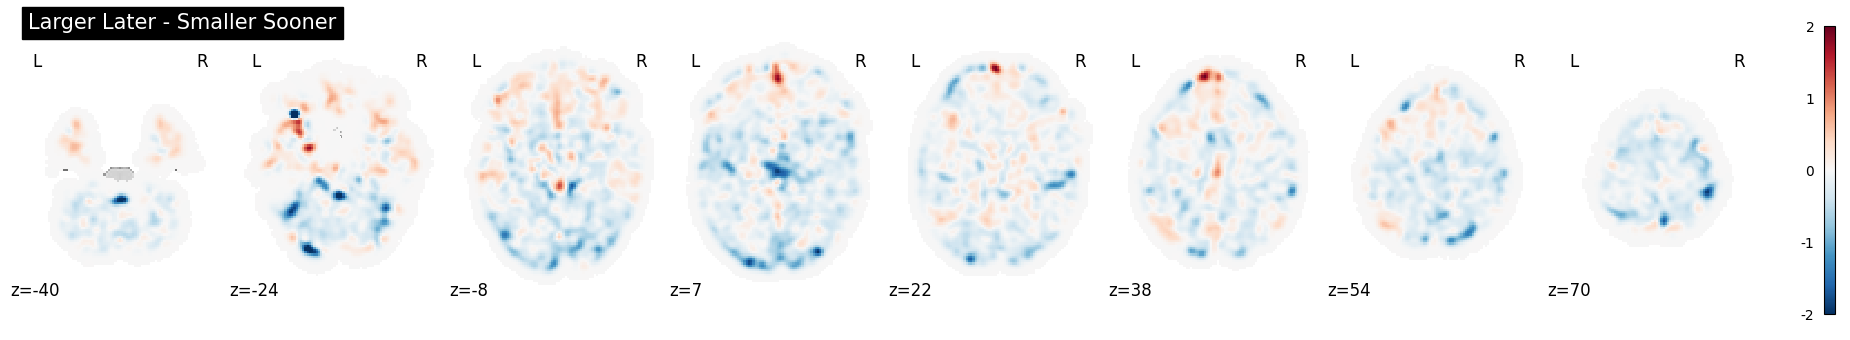

In [5]:
sub_id = 'dmp0011'
run = '1'

output_dir = Path(
    f'/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/derivatives/analysis_output/beta_series/first_level/sub-{sub_id}/contrast_estimates'
)

# Define consistent z-slice coordinates
z_coords = np.linspace(-40, 70, 8)

# Check ll - ss contrast
ll_minus_ss = (
    output_dir
    / f'sub-{sub_id}_ses-scan1_task-itc_run-{run}_contrast-ll_minus_ss_output-effectsize.nii.gz'
)

# Smoothing since I didn't smooth in the analysis
ll_minus_ss_smooth = image.smooth_img(str(ll_minus_ss), fwhm=6)


plotting.plot_stat_map(
    ll_minus_ss_smooth,
    display_mode='z',
    cut_coords=z_coords,
    title='Larger Later - Smaller Sooner',
    vmax=2,
)
plt.show()

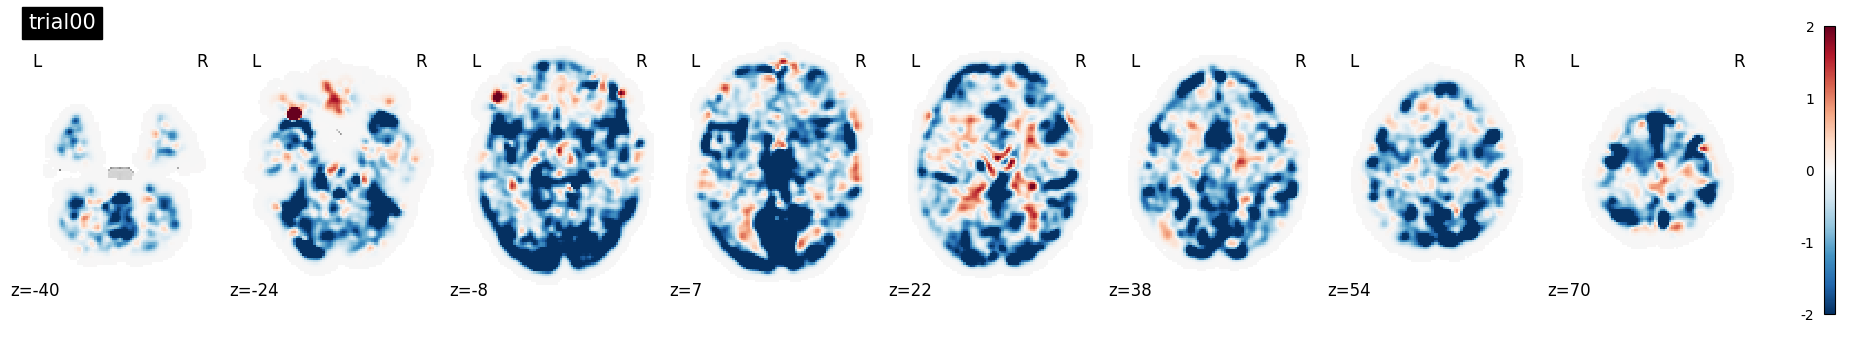

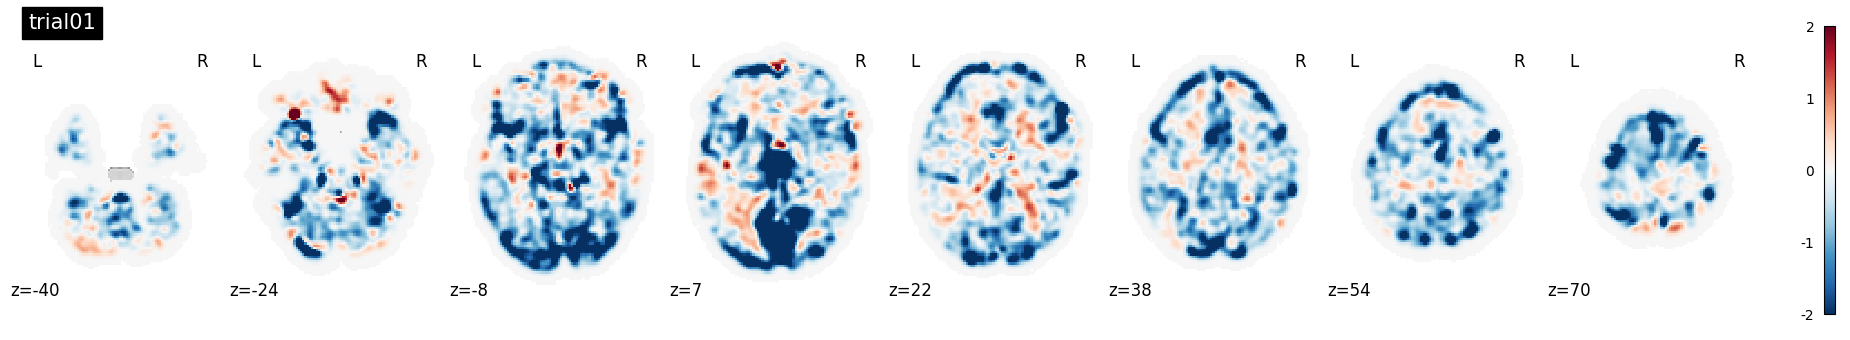

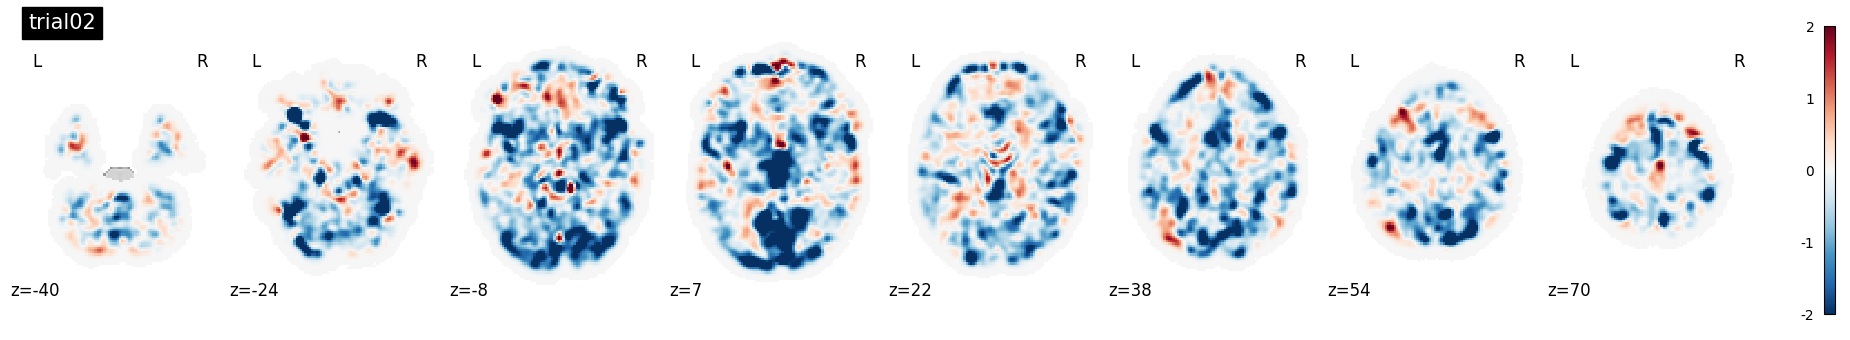

In [6]:
# Check all trial-level maps
trial_files = sorted(
    output_dir.glob(
        f'sub-{sub_id}_ses-scan1_task-itc_run-{run}_contrast-trial*-effectsize.nii.gz'
    )
)
for f in trial_files[:3]:  # Just plot the first 3 for now
    f_smooth = image.smooth_img(str(f), fwhm=6)
    plotting.plot_stat_map(
        f_smooth,
        display_mode='z',
        cut_coords=z_coords,
        title=f.name.split('_contrast-')[1].split('_')[0],
        vmax=2,
    )
    plt.show()

### The following is developmental code
A pdf is created just after this that generates this grid image for each subject/run.

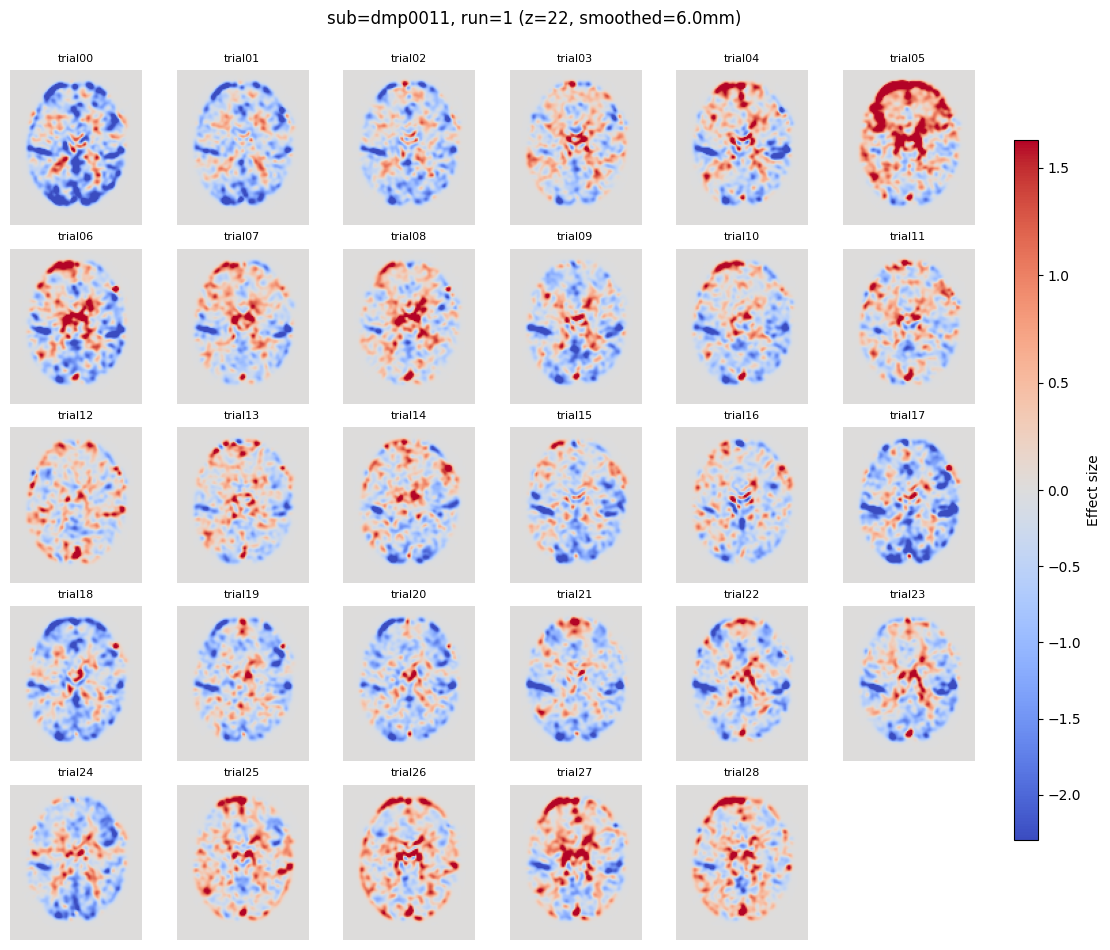

In [7]:
# --- Grid QA of trial betas (first subject/run) ---

good_subs = pd.read_csv(
    cfg.subject_lists / 'initial_qa_pass_and_mask_pass_subjects_runs.csv'
)
first = good_subs.iloc[0]
sub_id = first['sub_id']
run = int(first['run'])

output_dir = (
    Path(cfg.output_root)
    / 'beta_series'
    / 'first_level'
    / f'sub-{sub_id}'
    / 'contrast_estimates'
)
trial_files = sorted(
    output_dir.glob(
        f'sub-{sub_id}_ses-*_task-*_run-{run}_contrast-trial*_output-effectsize.nii.gz'
    ),
)

if not trial_files:
    raise FileNotFoundError(f'No trial beta maps found in {output_dir}')

# Determine z-index for world z=22 using the first image
z_world = 22
img0 = nib.load(str(trial_files[0]))
affine = img0.affine
ijk = np.linalg.inv(affine) @ np.array([0, 0, z_world, 1])
z_idx = int(np.round(ijk[2]))
z_idx = int(np.clip(z_idx, 0, img0.shape[2] - 1))

# Load slices and compute a shared color range (percentile-based)
slices = []
all_vals = []
for f in trial_files:
    img = image.smooth_img(str(f), fwhm=cfg.smoothing_fwhm)
    data = img.get_fdata()
    sl = data[:, :, z_idx]
    slices.append(sl)
    all_vals.append(sl.ravel())

all_vals = np.concatenate(all_vals)
vmin = float(np.nanpercentile(all_vals, 1))
vmax = float(np.nanpercentile(all_vals, 99))
if vmin == vmax:
    vmax = vmin + 1.0

norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# Use gridspec to reserve space for the colorbar and title
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(
    5, 6, left=0.05, right=0.88, top=0.92, bottom=0.05, wspace=0.02, hspace=0.15
)
axes = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(6)]

for ax, sl, f in zip(axes, slices, trial_files):
    im = ax.imshow(np.rot90(sl), cmap='coolwarm', norm=norm)
    ax.set_title(Path(f).name.split('_contrast-')[1].split('_')[0], fontsize=8)
    ax.axis('off')

# Turn off any unused panels
for ax in axes[len(slices) :]:
    ax.axis('off')

# Single colorbar for the grid (dedicated axis)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Effect size', rotation=90)

_ = fig.suptitle(
    f'sub={sub_id}, run={run} (z={z_world}, smoothed={cfg.smoothing_fwhm}mm)', y=0.98
)
plt.show()

In [8]:
from pathlib import Path

from qa_output import build_beta_map_qa_pdf

### It is expected that dmp0063/run2 will fail
They were missing many trials in that run, so the model wasn't estimated.

In [9]:
good_subs_file = cfg.subject_lists / 'initial_qa_pass_and_mask_pass_subjects_runs.csv'
good_subs = pd.read_csv(good_subs_file)

figures_dir = Path(cfg.output_root) / 'beta_series' / 'figures'
output_pdf = figures_dir / 'beta_map_qa.pdf'

summary = build_beta_map_qa_pdf(
    cfg,
    good_subs=good_subs,
    output_pdf=output_pdf,
    fwhm=cfg.smoothing_fwhm,
    gc_every=10,
    verbose=True,
)
summary

No trial beta maps found for sub=dmp0063, run=2
Processed 25/440 runs
Processed 50/440 runs
Processed 75/440 runs
Processed 100/440 runs
Processed 125/440 runs
Processed 150/440 runs
Processed 175/440 runs
Processed 200/440 runs
Processed 225/440 runs
Processed 250/440 runs
Processed 275/440 runs
Processed 300/440 runs
Processed 325/440 runs
Processed 350/440 runs
Processed 375/440 runs
Processed 400/440 runs
Processed 425/440 runs


{'output_pdf': '/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/derivatives/analysis_output/beta_series/figures/beta_map_qa.pdf',
 'n_total_runs': 440,
 'n_written': 439,
 'n_missing': 1}